In [2]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets

  Using cached transformers-4.15.0-py3-none-any.whl (3.4 MB)
  Using cached huggingface_hub-0.2.1-py3-none-any.whl (61 kB)
  Using cached tokenizers-0.10.3-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached regex-2021.11.10-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (748 kB)
  Using cached filelock-3.4.1-py3-none-any.whl (9.9 kB)
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached sentencepiece-0.1.96-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached nltk-3.6.7-py3-none-any.whl (1.5 MB)
  Using cached ipywidgets-7.6.5-py2.py3-none-any.whl (121 kB)
  Using cached jupyterlab_widgets-1.0.2-py3-none-any.whl (243 kB)
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
  Using cached widgetsnbextension-3.5.2-py2.py3-none-any.whl (1.6 MB)
  Using cached jedi-0.17.2-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.7.1-py2.py3-none-any.whl (109 k

In [4]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders

from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from seqeval.metrics import accuracy_score, classification_report,f1_score
from sklearn.metrics import matthews_corrcoef,classification_report
import engine
# from model_new import EntityModel
import torch.nn as nn
from tqdm import tqdm

In [4]:
# Read the data
def process_data(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,model_type):
    
    dataObj = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df= dataObj.createDf() # get dataframe from files
    obj_tokenized = createTokenizedDf(df,model_type)
    df_new= obj_tokenized.convertDf()
    train_data = CompDataset(df_new,model_type)
    return train_data


In [5]:
#loading dev/eval data
dataset_eval = process_data(config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval,model_type = 'xlm')
len(dataset_eval)

1000

In [6]:
dataObj = loadDatafromFile(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags)
df= dataObj.createDf() 
df
# list(df.source)

,source,target,src_tokens,tar_tokens
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,"However , a disappointing ninth in China meant...",Eine enttäuschende Neunte in China bedeutete j...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...,OK BAD OK BAD OK BAD OK OK OK OK OK OK OK OK O...
2,"In his diary , Chase wrote that the release of...","In seinem Tagebuch , Chase schrieb , dass die ...",OK OK OK OK BAD BAD OK OK OK OK OK OK OK OK BA...,OK OK OK OK OK OK OK OK OK BAD OK BAD OK OK OK...
3,Heavy arquebuses mounted on wagons were called...,Schwere Arquebuses auf Waggons montiert wurden...,OK BAD BAD OK OK OK OK OK OK OK OK,OK OK OK BAD OK OK OK OK BAD BAD OK OK OK OK O...
4,Once North Pacific salmon die off after spawni...,Sobald der nordpazifische Lachs nach dem Laich...,OK OK OK OK BAD OK OK OK OK OK BAD OK BAD OK O...,OK OK OK BAD OK OK OK BAD OK OK OK OK OK OK OK...
...,...,...,...,...
6995,Some may also discourage or disallow unsanitar...,Einige können auch unhygienische Praktiken wie...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
6996,"In the late 1860s , the crinolines disappeared...",In den späten 1860er Jahren verschwanden die K...,OK OK OK OK OK OK OK OK OK OK BAD BAD OK OK OK...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
6997,"Disco was criticized as mindless , consumerist...","Disco wurde als geistlos , konsumistisch , übe...",OK OK OK OK BAD OK BAD OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
6998,Planters would then fill large hogsheads with ...,Die Pflanzer würden dann große Heuschrecken mi...,OK OK OK BAD OK BAD OK OK BAD BAD OK OK OK OK OK,OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK...


In [12]:
import DataAugmentation
DataAugmentation = reload(DataAugmentation)
from DataAugmentation import DataAugmentation

In [7]:
dataaug_obj = DataAugmentation(df,swap_words=2,syn_words=4,del_words_prob=0.2,num_sentences=2)  
# swapDataset = dataaug_obj.random_swap()
del_augDataset = dataaug_obj.random_deletion()
# del_augDataset = del_augDataset[7000:]
# syn_dataset = dataaug_obj.synonym_replacement()
# syn_dataset = syn_dataset[7000:]
# frames = [swapDataset , del_augDataset,syn_dataset]
# aug_df  = pd.concat(frames)
del_augDataset

,source,target,src_tokens,tar_tokens
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,"However , a disappointing ninth in China meant...",Eine enttäuschende Neunte in China bedeutete j...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...,OK BAD OK BAD OK BAD OK OK OK OK OK OK OK OK O...
2,"In his diary , Chase wrote that the release of...","In seinem Tagebuch , Chase schrieb , dass die ...",OK OK OK OK BAD BAD OK OK OK OK OK OK OK OK BA...,OK OK OK OK OK OK OK OK OK BAD OK BAD OK OK OK...
3,Heavy arquebuses mounted on wagons were called...,Schwere Arquebuses auf Waggons montiert wurden...,OK BAD BAD OK OK OK OK OK OK OK OK,OK OK OK BAD OK OK OK OK BAD BAD OK OK OK OK O...
4,Once North Pacific salmon die off after spawni...,Sobald der nordpazifische Lachs nach dem Laich...,OK OK OK OK BAD OK OK OK OK OK BAD OK BAD OK O...,OK OK OK BAD OK OK OK BAD OK OK OK OK OK OK OK...
...,...,...,...,...
20995,"was criticized as mindless , , overproduced an...","Disco wurde als geistlos , konsumistisch , übe...",OK OK OK BAD OK OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
20996,Planters would then fill hogsheads and them to...,Die Pflanzer würden dann große Heuschrecken mi...,OK OK OK BAD BAD BAD OK OK OK OK,OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK...
20997,Planters would then fill with tobacco and conv...,Die Pflanzer würden dann große Heuschrecken mi...,OK OK OK BAD OK OK BAD BAD OK OK OK OK OK,OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK...
20998,"He slew Krishna dangerous enemy Jarasandha , a...",Er tötete Krishnas gefährlichsten Feind Jarasa...,OK OK OK OK OK OK OK OK BAD OK OK OK OK OK OK ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...


In [9]:
del_augDataset.iloc[41995:].values

array([['Slovak partisans in the Crimea Odessa assisted Soviet partisans .',
        'Slowakische Partisanen auf der Krim und Odessa unterstützten sowjetische Partisanen .',
        'OK OK OK OK OK OK OK OK OK OK',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK'],
       ['Assisting Sukarno as supreme commander ABRI , would be an ABRI chief of staff',
        'Sukarno als Oberbefehlshaber von ABRI zu unterstützen , wäre ein Stabschef von ABRI .',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK'],
       [', the pleadings between Jean de from and Arnaud de Laforcade , inhabitant of Fourré .',
        ', das Gerichtsverfahren zwischen Jean de Pee von Laborde und Arnaud de Laforcade , Einwohner von Fourré .',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK',
        'OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK 

In [7]:
del_augDataset =del_augDataset.sample(frac=1).reset_index(drop=True)
del_augDataset

,source,target,src_tokens,tar_tokens
0,B covered convoy MW 16 of one tanker escorted ...,Die Operation Quadrangle B umfasste den Konvoi...,OK OK OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,Sun Quan continued to recognize his jure to We...,Sun Quan erkannte weiterhin seine De-jure-Ober...,OK OK OK OK OK OK OK OK OK OK OK BAD OK OK OK ...,OK OK OK OK OK OK OK OK OK OK OK OK BAD OK OK ...
2,The Hornet and the Gremlin shared platforms .,Die Hornet und die späteren Gremlin teilten Pl...,OK OK OK OK OK OK OK OK,OK BAD OK OK OK OK OK OK OK OK OK OK OK OK BAD...
3,Both the Union Confederacy soon up with plans ...,Sowohl die Union als auch die Konföderation ka...,OK OK OK OK OK OK OK BAD OK OK OK BAD,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK B...
4,The peasants many the scattered plunderers .,Die Bauern töteten viele der zerstreuten Plünd...,OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
...,...,...,...,...
20995,Reversals and compensation the survivors and t...,Reversals des Erreichers und Entschädigung für...,BAD OK OK BAD OK OK BAD OK,OK BAD OK BAD OK BAD OK OK OK OK OK BAD OK BAD...
20996,The Creek Association within the .,Die Darby Creek Valley Association ist innerha...,OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK BAD OK ...
20997,Electric trains to via the line commenced on 2...,Elektrische Züge nach Hornsby über die Hauptli...,OK OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
20998,The Group painted figures combined or palmette...,Die Phantomgruppe malte hauptsächlich verhüllt...,OK OK OK OK OK OK BAD OK OK,OK OK OK OK OK OK OK OK OK BAD OK OK OK OK OK ...


In [19]:
import data_utils
data_utils=reload(data_utils)
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders


In [8]:
obj_tokenized = createTokenizedDf(del_augDataset,model_type = 'xlm')
df_new= obj_tokenized.convertDf()
# enc_label = preprocessing.LabelEncoder()
# df_new['labels']= enc_label.fit_transform(df_new['labels'])
train_data = CompDataset(df_new, model_type = 'xlm')

In [9]:
print(len(train_data))
train_data[0]

21000


(tensor([     0,  17151,  12426,   2765,    113,    527, 110896,  36997,     71,
          20387,   2189,    141,     99, 183124,     23,  58020,      6,      5,
              2,      2,    656,  58020,    656, 138438,     13,    656,  17151,
            656,  12426,   2765,    656,    113,    656,    527, 110896,    656,
          20387,   2189,    141,    656,     23,    656, 183124,    656,      6,
              5,    656,      2,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [10]:
# dataloaders
loader_obj = createDataloaders(train_data,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
len(train_dataloader)

1313

In [11]:
loader_obj = createDataloaders(dataset_eval,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
len(val_dataloader)

125

In [12]:
batch = next(iter(val_dataloader))
batch[0][0]

[2022-01-10 20:30:55.834 pytorch-1-6-gpu-py-ml-g4dn-8xlarge-d01940f40012030c1b9f0e178db4:31 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-10 20:30:55.867 pytorch-1-6-gpu-py-ml-g4dn-8xlarge-d01940f40012030c1b9f0e178db4:31 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


tensor([     0,    581,  13579,    721,   1799,    927,      7,   5117,  43780,
           297,    390,    884,   1505,   6431, 177592,     23,    543,  12977,
             6,      5,      2,      2,    656,   1310,    656, 106971,    656,
         26842,    150,  92733,    656,   4180,    656,  94756,      7,    656,
           543,  12977,    656,    542,    656,    884,   1505,   6431,    656,
        177592,    656, 232307,    656,      6,      5,    656,      2,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [15]:
def loss_fn(output,target,mask):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)    
    )
    loss = lfn(active_logits,active_labels)
    return loss

In [13]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaForTokenClassification.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
#         self.out_tag = nn.Linear(768, 2)
    
    def forward(self, ids, attention_mask, labels):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                labels = labels,return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
#         tag = self.out_tag(bo_tag)  
        
#         loss_tag = loss_fn(outputs[1],labels,attention_mask)
        
#         return bo_tag,loss
        return outputs[0], outputs[1]
        

In [23]:
# b_input_ids = batch[0].cuda()
# b_input_mask = batch[1].cuda()
# b_labels = batch[2].cuda()
# outputs = model(b_input_ids, 
#                 b_input_mask,
#                 labels=b_labels)

In [14]:
model = EntityModel()
model.cuda()
# model = nn.DataParallel(model)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

EntityModel(
  (bert): XLMRobertaForTokenClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_

In [26]:
# print(model)

In [38]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# outputs[0]

In [17]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [18]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(del_augDataset) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=5)

In [19]:
config.EPOCHS

20

In [40]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(val_dataloader, model)
print(classification_report(labels_test,preds_test)) # validation data

100%|██████████| 125/125 [00:13<00:00,  9.13it/s]


Average F1 Validation score for class 0 : 0.0
Average F1 Validation score for class 1 : 0.9294044211680166
Average Accuracy Validation score  : 0.8681190540521324
Average mcc Validation score  : 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9274
           1       0.87      1.00      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.43      0.50      0.46     70321
weighted avg       0.75      0.87      0.81     70321



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted 

In [31]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(train_dataloader, model)
print(classification_report(labels_test,preds_test))

100%|██████████| 1313/1313 [04:41<00:00,  4.67it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for class 0 : 0.0
Average F1 Validation score for class 1 : 0.9329219141459792
Average Accuracy Validation score  : 0.8742770810435381
Average mcc Validation score  : 0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    175584
           1       0.87      1.00      0.93   1221011

    accuracy                           0.87   1396595
   macro avg       0.44      0.50      0.47   1396595
weighted avg       0.76      0.87      0.82   1396595



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
config = reload(config)

In [20]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [ ]:

best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta__DataAugmentation_deletion.txt', 'w') as f:
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[5],train_metrics[6]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[5],test_metrics[6]))
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-2])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(test_metrics[4]): #mcc score for early stopping
                  break  # early stop criterion is met, we can stop now
            if test_metrics[4] >  best_accuracy:
                torch.save(model.state_dict(), './models/training_data/model_xlmrobertatokenclassificationmodel_DataAugmentationdeletion_earlystopping.bin')
                best_accuracy = test_metrics[4]

  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 1 of 20


100%|██████████| 1313/1313 [17:21<00:00,  1.26it/s]


Average F1 Training score for class 0 : 0.2615500336504836
Average F1 Training score for class 1 : 0.9345597811447877
Average Accuracy Training score  : 0.8797738091572056
Average mcc Training score  : 0.2651824495268958


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.57      0.17      0.26    175469
           1       0.89      0.98      0.93   1220874

    accuracy                           0.88   1396343
   macro avg       0.73      0.58      0.60   1396343
weighted avg       0.85      0.88      0.85   1396343



100%|██████████| 125/125 [00:14<00:00,  8.36it/s]


Average F1 Validation score for class 0 : 0.19965325303403597
Average F1 Validation score for class 1 : 0.9323658459474256
Average Accuracy Validation score  : 0.8752719671221968
Average mcc Validation score  : 0.239580020040288
              precision    recall  f1-score   support

           0       0.65      0.12      0.20      9274
           1       0.88      0.99      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.77      0.55      0.57     70321
weighted avg       0.85      0.88      0.84     70321

Train Loss = 0.30186314803675124 Valid Loss = 0.36236758852005
Epoch 2 of 20


100%|██████████| 1313/1313 [17:26<00:00,  1.25it/s]


Average F1 Training score for class 0 : 0.582702842835604
Average F1 Training score for class 1 : 0.9510571595917309
Average Accuracy Training score  : 0.9123897208637133
Average mcc Training score  : 0.5492335688726299


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.73      0.49      0.58    175469
           1       0.93      0.97      0.95   1220874

    accuracy                           0.91   1396343
   macro avg       0.83      0.73      0.77   1396343
weighted avg       0.90      0.91      0.90   1396343



100%|██████████| 125/125 [00:14<00:00,  8.37it/s]


Average F1 Validation score for class 0 : 0.2952108063855915
Average F1 Validation score for class 1 : 0.9329658093703038
Average Accuracy Validation score  : 0.8775756886278636
Average mcc Validation score  : 0.29710170815769477
              precision    recall  f1-score   support

           0       0.61      0.19      0.30      9274
           1       0.89      0.98      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.75      0.59      0.61     70321
weighted avg       0.85      0.88      0.85     70321

Train Loss = 0.21957505939234692 Valid Loss = 0.4146628511548042
Epoch 3 of 20


100%|██████████| 1313/1313 [17:23<00:00,  1.26it/s]


Average F1 Training score for class 0 : 0.7260718851487996
Average F1 Training score for class 1 : 0.9645590209155037
Average Accuracy Training score  : 0.9372382000697537
Average mcc Training score  : 0.6951744789457047


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.66      0.73    175469
           1       0.95      0.98      0.96   1220874

    accuracy                           0.94   1396343
   macro avg       0.88      0.82      0.85   1396343
weighted avg       0.93      0.94      0.93   1396343



100%|██████████| 125/125 [00:14<00:00,  8.43it/s]


Average F1 Validation score for class 0 : 0.3250078051826413
Average F1 Validation score for class 1 : 0.9323476492216225
Average Accuracy Validation score  : 0.8770210890061291
Average mcc Validation score  : 0.31059104690040285
              precision    recall  f1-score   support

           0       0.59      0.22      0.33      9274
           1       0.89      0.98      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.74      0.60      0.63     70321
weighted avg       0.85      0.88      0.85     70321

Train Loss = 0.16070287873555664 Valid Loss = 0.5265298784971237


  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 4 of 20


100%|██████████| 1313/1313 [17:21<00:00,  1.26it/s]


Average F1 Training score for class 0 : 0.799406326297758
Average F1 Training score for class 1 : 0.9729199188625804
Average Accuracy Training score  : 0.9522817817685196
Average mcc Training score  : 0.7740163537097449


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.85      0.76      0.80    175469
           1       0.97      0.98      0.97   1220874

    accuracy                           0.95   1396343
   macro avg       0.91      0.87      0.89   1396343
weighted avg       0.95      0.95      0.95   1396343



100%|██████████| 125/125 [00:14<00:00,  8.46it/s]


Average F1 Validation score for class 0 : 0.3845727738540369
Average F1 Validation score for class 1 : 0.9295721077654517
Average Accuracy Validation score  : 0.873608168256993
Average mcc Validation score  : 0.3374939146539046
              precision    recall  f1-score   support

           0       0.54      0.30      0.38      9274
           1       0.90      0.96      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.63      0.66     70321
weighted avg       0.85      0.87      0.86     70321

Train Loss = 0.12241293019093771 Valid Loss = 0.5541496854424477


  0%|          | 0/1313 [00:00<?, ?it/s]

Epoch 5 of 20


100%|██████████| 1313/1313 [17:19<00:00,  1.26it/s]


Average F1 Training score for class 0 : 0.8419569096947277
Average F1 Training score for class 1 : 0.978205012235997
Average Accuracy Training score  : 0.9616927932463585
Average mcc Training score  : 0.8209190438044313


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.87      0.81      0.84    175469
           1       0.97      0.98      0.98   1220874

    accuracy                           0.96   1396343
   macro avg       0.92      0.90      0.91   1396343
weighted avg       0.96      0.96      0.96   1396343



100%|██████████| 125/125 [00:14<00:00,  8.49it/s]


Average F1 Validation score for class 0 : 0.37849370599530613
Average F1 Validation score for class 1 : 0.9309612027081473
Average Accuracy Validation score  : 0.8757270232220816
Average mcc Validation score  : 0.33867498018607184
              precision    recall  f1-score   support

           0       0.56      0.29      0.38      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.63      0.65     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.09792534601984593 Valid Loss = 0.6254125117063523
Epoch 6 of 20


100%|██████████| 1313/1313 [17:21<00:00,  1.26it/s]


Average F1 Training score for class 0 : 0.8738781349449651
Average F1 Training score for class 1 : 0.9823694297879011
Average Accuracy Training score  : 0.9690634750917217
Average mcc Training score  : 0.8565966383231011


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.85      0.87    175469
           1       0.98      0.99      0.98   1220874

    accuracy                           0.97   1396343
   macro avg       0.94      0.92      0.93   1396343
weighted avg       0.97      0.97      0.97   1396343



100%|██████████| 125/125 [00:14<00:00,  8.43it/s]


Average F1 Validation score for class 0 : 0.35037921453780885
Average F1 Validation score for class 1 : 0.9320557628117023
Average Accuracy Validation score  : 0.8769784274967648
Average mcc Validation score  : 0.32494383063665994
              precision    recall  f1-score   support

           0       0.58      0.25      0.35      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.74      0.61      0.64     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.0788113628709171 Valid Loss = 0.7241875883340836
Epoch 7 of 20


100%|██████████| 1313/1313 [17:28<00:00,  1.25it/s]


Average F1 Training score for class 0 : 0.8995994868334554
Average F1 Training score for class 1 : 0.9858342332756799
Average Accuracy Training score  : 0.97517157317364
Average mcc Training score  : 0.885591342589789


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.89      0.90    175469
           1       0.98      0.99      0.99   1220874

    accuracy                           0.98   1396343
   macro avg       0.95      0.94      0.94   1396343
weighted avg       0.97      0.98      0.97   1396343



100%|██████████| 125/125 [00:14<00:00,  8.40it/s]


Average F1 Validation score for class 0 : 0.3753669889008235
Average F1 Validation score for class 1 : 0.9311398280666577
Average Accuracy Validation score  : 0.875954551272024
Average mcc Validation score  : 0.3372676134943797
              precision    recall  f1-score   support

           0       0.56      0.28      0.38      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.62      0.65     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.06316519014094726 Valid Loss = 0.7973662937879562
Epoch 8 of 20


100%|██████████| 1313/1313 [17:27<00:00,  1.25it/s]


Average F1 Training score for class 0 : 0.9200131456806637
Average F1 Training score for class 1 : 0.9886556731447
Average Accuracy Training score  : 0.9801295240496067
Average mcc Training score  : 0.9087515834130034


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.91      0.92    175469
           1       0.99      0.99      0.99   1220874

    accuracy                           0.98   1396343
   macro avg       0.96      0.95      0.95   1396343
weighted avg       0.98      0.98      0.98   1396343



100%|██████████| 125/125 [00:14<00:00,  8.40it/s]


Average F1 Validation score for class 0 : 0.35878483258186117
Average F1 Validation score for class 1 : 0.9317536365281285
Average Accuracy Validation score  : 0.8766371354218512
Average mcc Validation score  : 0.3288943931752005
              precision    recall  f1-score   support

           0       0.57      0.26      0.36      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.62      0.65     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.05119086278925926 Valid Loss = 0.8605518705844879
Epoch 9 of 20


100%|██████████| 1313/1313 [17:19<00:00,  1.26it/s]


Average F1 Training score for class 0 : 0.936250768426435
Average F1 Training score for class 1 : 0.9909219282557437
Average Accuracy Training score  : 0.9841070567904877
Average mcc Training score  : 0.9272131968318944


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.93      0.94    175469
           1       0.99      0.99      0.99   1220874

    accuracy                           0.98   1396343
   macro avg       0.97      0.96      0.96   1396343
weighted avg       0.98      0.98      0.98   1396343



100%|██████████| 125/125 [00:14<00:00,  8.48it/s]


Average F1 Validation score for class 0 : 0.3712626995645864
Average F1 Validation score for class 1 : 0.9317053175891914
Average Accuracy Validation score  : 0.8767935609561867
Average mcc Validation score  : 0.3370126981431409
              precision    recall  f1-score   support

           0       0.57      0.28      0.37      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.62      0.65     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.0413221878755727 Valid Loss = 0.8877145833969117
Epoch 10 of 20


100%|██████████| 1313/1313 [17:30<00:00,  1.25it/s]


Average F1 Training score for class 0 : 0.9493748836409985
Average F1 Training score for class 1 : 0.9927666744013119
Average Accuracy Training score  : 0.9873419353267786
Average mcc Training score  : 0.9421581881985379


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.94      0.95    175469
           1       0.99      0.99      0.99   1220874

    accuracy                           0.99   1396343
   macro avg       0.97      0.97      0.97   1396343
weighted avg       0.99      0.99      0.99   1396343



100%|██████████| 125/125 [00:14<00:00,  8.37it/s]


Average F1 Validation score for class 0 : 0.35547103569338795
Average F1 Validation score for class 1 : 0.9305977790029141
Average Accuracy Validation score  : 0.8746889264942194
Average mcc Validation score  : 0.3211012915451525
              precision    recall  f1-score   support

           0       0.55      0.26      0.36      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.61      0.64     70321
weighted avg       0.85      0.87      0.85     70321

Train Loss = 0.03282821915514614 Valid Loss = 0.9630370870828628
terminating because of early stopping!


In [6]:
val_loss_lst = [(0.36236758852005, 0.19965325303403597, 0.9323658459474256, 0.8752719671221968, 0.239580020040288), (0.4146628511548042, 0.2952108063855915, 0.9329658093703038, 0.8775756886278636, 0.29710170815769477), (0.5265298784971237, 0.3250078051826413, 0.9323476492216225, 0.8770210890061291, 0.31059104690040285), (0.5541496854424477, 0.3845727738540369, 0.9295721077654517, 0.873608168256993, 0.3374939146539046), (0.6254125117063523, 0.37849370599530613, 0.9309612027081473, 0.8757270232220816, 0.33867498018607184), (0.7241875883340836, 0.35037921453780885, 0.9320557628117023, 0.8769784274967648, 0.32494383063665994), (0.7973662937879562, 0.3753669889008235, 0.9311398280666577, 0.875954551272024, 0.3372676134943797), (0.8605518705844879, 0.35878483258186117, 0.9317536365281285, 0.8766371354218512, 0.3288943931752005), (0.8877145833969117, 0.3712626995645864, 0.9317053175891914, 0.8767935609561867, 0.3370126981431409), (0.9630370870828628, 0.35547103569338795, 0.9305977790029141, 0.8746889264942194, 0.3211012915451525)]
train_loss_lst = [(0.30186314803675124, 0.2615500336504836, 0.9345597811447877, 0.8797738091572056, 0.2651824495268958), (0.21957505939234692, 0.582702842835604, 0.9510571595917309, 0.9123897208637133, 0.5492335688726299), (0.16070287873555664, 0.7260718851487996, 0.9645590209155037, 0.9372382000697537, 0.6951744789457047), (0.12241293019093771, 0.799406326297758, 0.9729199188625804, 0.9522817817685196, 0.7740163537097449), (0.09792534601984593, 0.8419569096947277, 0.978205012235997, 0.9616927932463585, 0.8209190438044313), (0.0788113628709171, 0.8738781349449651, 0.9823694297879011, 0.9690634750917217, 0.8565966383231011), (0.06316519014094726, 0.8995994868334554, 0.9858342332756799, 0.97517157317364, 0.885591342589789), (0.05119086278925926, 0.9200131456806637, 0.9886556731447, 0.9801295240496067, 0.9087515834130034), (0.0413221878755727, 0.936250768426435, 0.9909219282557437, 0.9841070567904877, 0.9272131968318944), (0.03282821915514614, 0.9493748836409985, 0.9927666744013119, 0.9873419353267786, 0.9421581881985379)]


train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test))

loss_train : [0.30186314803675124, 0.21957505939234692, 0.16070287873555664, 0.12241293019093771, 0.09792534601984593, 0.0788113628709171, 0.06316519014094726, 0.05119086278925926, 0.0413221878755727, 0.03282821915514614] 
 loss_test :  [0.36236758852005, 0.4146628511548042, 0.5265298784971237, 0.5541496854424477, 0.6254125117063523, 0.7241875883340836, 0.7973662937879562, 0.8605518705844879, 0.8877145833969117, 0.9630370870828628] 
 f1_class0_train : [0.2615500336504836, 0.582702842835604, 0.7260718851487996, 0.799406326297758, 0.8419569096947277, 0.8738781349449651, 0.8995994868334554, 0.9200131456806637, 0.936250768426435, 0.9493748836409985] 
 f1_class0_test : [0.19965325303403597, 0.2952108063855915, 0.3250078051826413, 0.3845727738540369, 0.37849370599530613, 0.35037921453780885, 0.3753669889008235, 0.35878483258186117, 0.3712626995645864, 0.35547103569338795] 
 f1_class1_train : [0.9345597811447877, 0.9510571595917309, 0.9645590209155037, 0.9729199188625804, 0.978205012235997, 0

In [2]:
print(loss.grad_fn)

NameError: name 'loss' is not defined

In [12]:
print('Max mcc score achieved at :',np.argmax(mcc_score_test),'epoch')

Max mcc score achieved at : 4 epoch


In [7]:
import matplotlib.pyplot as plt

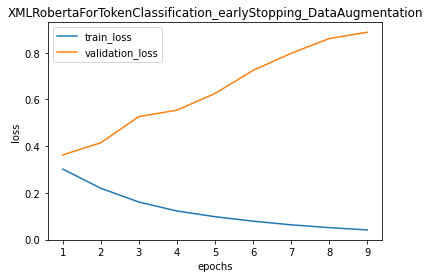

In [8]:
epoch = 9
epochs = np.arange(1,epoch+1)
# print(epochs)
plt.plot(epochs,loss_train[:-1],label='train_loss')
plt.plot(epochs,loss_test[:-1],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('XMLRobertaForTokenClassification_earlyStopping_DataAugmentation')
plt.legend()
plt.show()

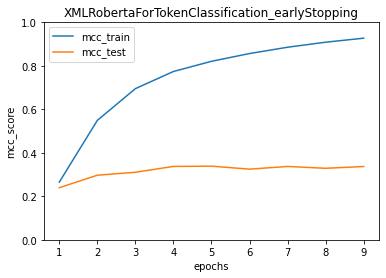

In [9]:
epoch = 9
epochs = np.arange(1,epoch+1)
plt.plot(epochs,mcc_score_train[:-1],label='mcc_train')
plt.plot(epochs,mcc_score_test[:-1],label='mcc_test')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.ylim(0.0,1.0)

plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.show()

In [53]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained('xlm-roberta-base')
config.num_labels

2

In [31]:
print(model)

DataParallel(
  (module): EntityModel(
    (bert): XLMRobertaForTokenClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(250002, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
              